# INTEGRATION OF A FUZZY RULE-BASED MICROSERVICE IN .NET FOR REAL-TIME CYBER THREAT MONITORING WITH INTERPRETABLE RISK RATINGS

«Інтеграція FLRB як мікросервісу в .NET для реального часу моніторингу кіберзагроз з інтерпретованою аналітикою» (секція Кібербезпека бізнесу). Короткий зміст. Робота зосереджена на архітектурі: як побудувати високопродуктивний .NET-мікросервіс, що приймає векторні ознаки на основі WordVec і результат селекції Random Forest, викликає SVM/RF для швидкої класифікації і застосовує FLRB для генерації інтерпретованих ризикових рейтингів. Оцінюються затримки, масштабованість і поведінка системи під навантаженням, а також надаються рекомендації щодо інтеграції з SIEM та іншими інструментами SOC.

https://github.com/mehalyna/FLRB-Net/blob/main/thesis.md

**Datasets**

https://www.kaggle.com/datasets/ramoliyafenil/text-based-cyber-threat-detection

https://www.kaggle.com/datasets/subhajournal/phishingemails

https://www.kaggle.com/datasets/mrwellsdavid/unsw-nb15


In [1]:
# imports section
import numpy as np
import math
from numpy import dot
from numpy.linalg import norm
from gensim import corpora, models, similarities
import string
import pandas as pd

import gensim.downloader as api
from gensim.models import Word2Vec

import itertools

import json
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

In [2]:
data = pd.read_csv('../resources/secur/Phishing_Email.csv')
# data = pd.read_csv('../resources/secur/cyber-threat-dataset/cyber-threat-intelligence-splited_train.csv')
# data = pd.read_csv('../resources/secur/cyber-threat-dataset/Cyber-Threat-Intelligence-Custom-Data_new_processed.csv')
# data = pd.read_csv('../resources/secur/nusw/UNSW_NB15_testing-set.csv')
# data = pd.read_csv('../resources/secur/nusw/NUSW-NB15_features.csv')
# data = pd.read_csv('../resources/secur/nusw/UNSW-NB15_1.csv')
# data = pd.read_csv('../resources/secur/nusw/UNSW-NB15_LIST_EVENTS.csv')

display(data.head())

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [3]:
corpus = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [5]:
encoded_df = pd.get_dummies(data, columns=["Email Type"])
display(encoded_df.head())

,Unnamed: 0,Email Text,Email Type_Phishing Email,Email Type_Safe Email
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",False,True
1,1,the other side of * galicismos * * galicismo *...,False,True
2,2,re : equistar deal tickets are you still avail...,False,True
3,3,\nHello I am your hot lil horny toy.\n I am...,True,False
4,4,software at incredibly low prices ( 86 % lower...,True,False


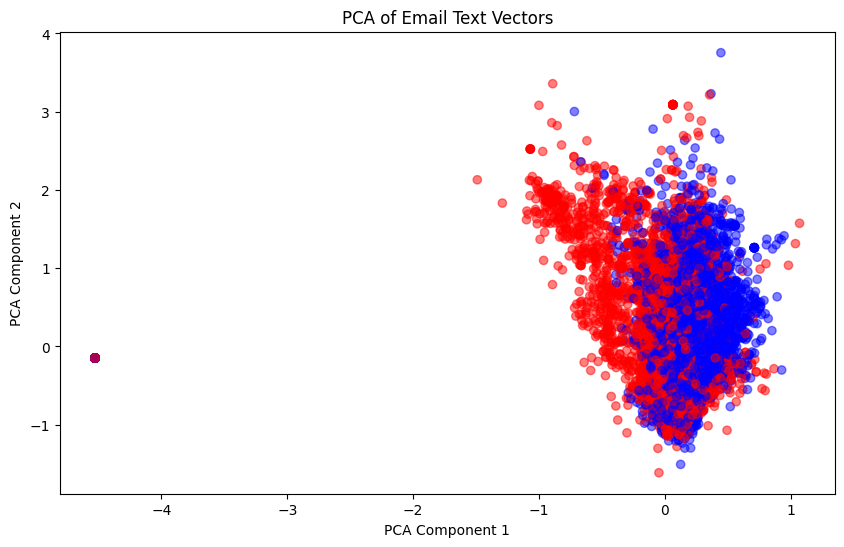

In [10]:
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.decomposition import PCA

def vectorize_text(text):
    words = word_tokenize(text.lower())
    word_vectors = []
    for word in words:
        if word in corpus:
            word_vectors.append(corpus[word])
    if word_vectors:
        text_vector = np.mean(word_vectors, axis=0)
    else:
        text_vector = np.zeros(corpus.vector_size)
    return text_vector

encoded_df['Text_Vector'] = encoded_df['Email Text'].apply(str).apply(vectorize_text)
# display(data[['Email Text', 'Text_Vector']].head())

# Apply PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
text_vectors = np.vstack(encoded_df['Text_Vector'].values)
reduced_vectors = pca.fit_transform(text_vectors)
encoded_df['PCA_1'] = reduced_vectors[:, 0]
encoded_df['PCA_2'] = reduced_vectors[:, 1]

colors = encoded_df["Email Type_Phishing Email"].map({True: "red", False: "blue"})

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(encoded_df['PCA_1'], encoded_df['PCA_2'], c=colors, alpha=0.5)
plt.title('PCA of Email Text Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()
